In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 6. 학습 관련 기술들 

이번 장에서 다룰 주제들:
- 가중치 매개변수의 최적값을 탐색하는 최적화 방법
- 가중치 매개변수 초깃값
- 하이퍼파라미터 설정 방법
- 오버피팅의 대응책: 정규화. (가중치 감소와 드롭아웃 등)

## 6.1 매개변수 갱신

손실함수의 값을 최소화하는 매개변수 최적 값을 찾는 것을 Optimization이라고 한다. 

지금까지 본 것은 기울기를 통해 이를 찾는 SGD 방법이었다. 이외의 방법도 알아보자. 

### 6.1.1 모험가 이야기

최적화 상황은 눈 감고 지도 없이 가장 낮은 골짜기를 찾는 모험가와 같다. 
 
SGD는 발바닥으로 기울기를 느껴 가장 크게 기울어진 방향으로 내려가는 것이다. 

### 6.1.2 확률적 경사 하강법 (SGD)

SGD는 수식으로

![SGD](../deep_learning_images/e_6.1.png "SGD equation")

이다. 

이를 구현해보면, 

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

보통 짤 때 이런 식으로 optimizer 여러 개를 가지고 

optimizer = SGD() 

와 같이 변수로 지정해주고 

optimizer.update(params, grads) 와 같은 식으로 돌린다. (여러 optimizer로 바꿔가며 할 수 있음.)

### 6.1.3 SGD의 단점

[fig6-1](../deep_learning_images/fig_6-1.png "f(x,y) = (1/20)*x^2 + y^2의 그래프")

<img src="../deep_learning_images/fig_6-1.png" width="500">

이는 A4용지를 구부린 뒤 중앙을 살짝 당긴 모양이다. (조금밖에 차이 안나지만 정 중앙이 최저점이긴 함.) 

와 같은 경우 기울기를 나타내면 

[fig6-2](../deep_learning_images/fig_6-2.png "기울기") 

<img src="../deep_learning_images/fig_6-2.png" width="500">


와 같이 되고, 여기에 SGD를 적용하면 

[fig6-3](../deep_learning_images/fig_6-3.png "최적화 갱신 경로") 

<img src="../deep_learning_images/fig_6-3.png" width="500">

이렇게 최적화 갱신 경로가 비효율적으로 나타난다. 


여기서 볼 수 있듯, SGD는 비등방성(antsotropy, 방향에 따라 성질이(여기서는 기울기) 달라지는 함수)에서 탐색 경로가 비효율적이다. 

즉, 기울기의 방향이 최솟값과 다른 방향이기 때문에 이런 문제가 발생하는 것이다. 

이에 대한 대안으로 
- Momentum
- AdaGrad
- Adam

을 소개한다. 

### 6.1.4 모멘텀

수식으론 다음과 같다. 

![e6-3](../deep_learning_images/e_6.3.png "e6.3")

![e6-4](../deep_learning_images/e_6.4.png "e6.4")

W는 가중치, aL/aW는 손실함수의 기울기, n(에타)는 학습률, v는 물리학에서의 속도에 해당. a(알파)는 물리학에서의 지면 마찰이나 공지 저항에 해당. 보통 0.9 정도로 설정. 

av 항은 물체가 아무 힘도 받지 않을 때 서서히 하강시키는 역할이다. 

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

모멘텀을 이용해 같은 함수에 대해 최적화를 진행하면 다음과 같이 된다. 

<img src="../deep_learning_images/fig_6-5.png" width="500">

왜 이렇게 되는가? 

x 축의 방향은 완만하지만 계속 내리막길이니 속도가 계속 붙고, y축의 방향은 가파르지만 골짜기처럼 왔다 갔다 할 때 기울기 +-가 계속 바뀌므로 속도가 늘었다 줄었다 한다. 

x 쪽은 갈수록 속도가 붙게 되고, SGD보다 덜 지그재그가 된다. 

### 6.1.5 AdaGrad 

학습률 n(에타)는 중요하다. 이를 잘 정하는 기술로 학습률 감소(learning rate decay)가 있다. 학습하며 학습률을 점점 줄여나가는 방법이다. 

AdaGrad는 각각의 매개변수에 적응적으로(adaptive) 학습률을 조정해준다. (매개변수 전체에 대해 공통으로 학습률 낮추는 것보다 나음.) 

수식으론 아래와 같다. 

![e6-5](../deep_learning_images/e_6.5.png "e6.5")

![e6-6](../deep_learning_images/e_6.6.png "e6.6")

h는 계속 기존 기울기를 제곱한 값을 더해가며 update된다. (o은 행렬의 원소별 곱셈) 

매개변수 갱신 시 1/sqrt(h)를 곱해 학습률을 조정한다. 

즉, 이는 매개변수의 원소 중 많이 움직인(크게 갱신된) 원소의 학습률을 낮춘다. 

<br>

식을 살펴보면, h는 계속 기울기를 제곱한 값을 더해주며 갱신되기 때문에 항상 커진다. 

다만 기울기가 1보다 클 경우는 h가 크게 커지고, 1보다 작을 경우 h가 아주 작게 커지는 차이가 있다. 

<h1 style='color:purple'>AdaGrad라도 평탄한 구간을 지나면 학습률*갱신거의안되는h*작은기울기 니까 거의 W가 update 더 이상 못하고 확정되는거 아닌가? </h1>


<br>

참고로, AdaGrad는 h에 과거 기울기를 제곱하며 더해가기 때문에 학습을 많이 진행하면 어느 순간 갱신량이 0이 되어 갱신되지 않게 된다. 

이를 해결하기 위한 방법으로 RMSProp이 있다. RMSProp은 과거의 모든 기울기를 균일하게 더하지 않고 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다. 

이는 지수이동평균(Exponential Moving Average, EMA)라고 하여 과거 기울기의 반영 규모를 기하급수적으로 감소시킨다. 

In [5]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 아주 작은 값 1e-7을 더해줘 설사 self.h[key]에 0이 담겨있어도 0으로 나누는 사태를 막아줌. 

이를 통해 최적화 문제를 풀어보면 다음과 같이 나타난다. 

<img src="../deep_learning_images/fig_6-6.png" width="500">

y축 방향으로의 기울기가 커서 처음엔 크게 움직이지만(h가 크게 커짐), 큰 움직임 만큼 갱신 정도도 큰 폭으로 작아져(학습률에 1/sqrt(h)를 곱해주니까) y축 방향의 갱신강도가 빠르게 약해진다. 

### 6.1.6 Adam 

앞의 모멘텀과 AdaGrad를 융합한 것이 Adam이다. (엄밀하진 않은 설명)

하이퍼파라미터의 편향보정이 진행된다는 점도 Adam의 특징이다. 

복잡해서 설명은 하지 않고, 구현은 ../common/optimizer.py 에 되어있다. 

결과는 아래와 같다. 

<img src="../deep_learning_images/fig_6-7.png" width="500">

직관적으로 보면 모멘텀과 같이 바닥 구르듯 부드럽게 움직이는데, 갱신 강도가 계속 약해지므로 좌우의(y축) 흔들림이 적다. 

참고로 Adam의 Hyperparameter는 3개이다. 

1. a (학습률)
2. 1차 모멘텀 계수 B1, 논문에선 0.9
3. 2차 모멘텀 계수 B2, 논문에선 0.999

### 6.1.7 어느 갱신 방법을 이용할 것인가? 

결과를 비교해보자. 

여기선 AdaGrad가 가장 낫지만, 이는 푸는 문제에 따라 달라진다. 

많은 연구에선 SGD를 기본으로 쓰고, 요즘은 Adam도 많이 쓰인다. 알아서 여러 가지 실험해보며 맞는걸 고르자. 

### 6.1.8 MNIST 데이터셋으로 본 갱신방법 비교

결과는 생략. 일반적으로 SGD보다 다른 기법이 빠르게 학습하고 loss function 최적화도 잘한다. 

## 6.2 가중치의 초깃값

가중치의 초깃값이 중요하다. 권장 초기값에 대해 배우고 실습을 해보자. 

### 6.2.1 초깃값을 0으로 하면? 

가중치 감소(weight decay)는 오버피팅을 억제한다. 

하지만 만약 극단적으로 모두 0이면 어떻게 될까? 안된다. (정확히는, 모두 균일한 값으로 설정해선 안됨.)

그 이유는 backpropagation 시 모든 가중치 값이 똑같이 갱신되기 때문. 

순전파시 모든 W가 같은 값이면 다음 층 뉴런도 모두 같은 값을 가지게 되고, 역전파에서도 덧셈은 말할 것도 없고 곱셈노드의 역전파를 생각하면 aL/aW에 같은 값이 곱해지기에 갱신을 해도 W에 변화가 없게 된다.

이렇게 되면 가중치를 여러 개 갖는 의미가 없어진다. 

즉, 가중치의 대칭적 구조를 무너뜨리려면 초깃값을 무작위로 설정해야 한다. 

### 6.2.2 은닉층의 활성화값 분포

가중치의 초깃값에 따라 은닉층 활성화 값들이 어떻게 변화하는지 살펴보자. (CS231n을 참고한 Sigmoid를 activation function으로 사용하는 5층 신경망)

실험 전체 소스 코드는 weight_init_activation_histogram.py에 있다. 

일단 가중치 w = np.random.randn(node_num, node_num) * 1(표준편차) 으로 뽑았는데, 이 표준편차를 바꿔가며 활성화 값들의 분포의 변화를 관찰하는 것이 실험의 목표이다. 

In [15]:
sd = 1

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) #1000개의 데이터 중 100개 뽑음. 
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개. 
activations = {} # 여기에 활성화 결과(활성화 값)을 저장. 

for i in range(hidden_layer_size):
    if i !=  0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * sd
#     w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # Xavier 초깃값
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

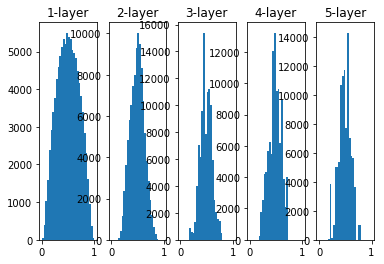

In [22]:
# 히스토그램 그리기 

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

볼 수 있듯, 활성화 값들이 0과 1에 치우쳐 분포되어 있다. 

시그모이드 함수는 아래와 같이 생겼기 때문에, 

<img src="../deep_learning_images/fig_3-8.png" width="400">

지금처럼 출력이 0 또는 1에 가까워지면 미분값이 0으로 수렴한다. 그러면 역전파의 기울기 값이 점점 작아지다가 사라지게 된다. (기울기 소실, gradient vanishing) 

기울기 소실은 층이 깊어지는 딥러닝에서 큰 문제가 될 수 있다. 

이번엔 똑같이 하되 sd를 0.01로 해보자. 

In [18]:
sd = 0.01 # sd를 설정했으니 위의 코드블럭을 그대로 돌린다. 

이번엔 반대로 0.5 부근에 집중됨을 볼 수 있다. 기울기 소실은 일어나지 않지만, 활성화 값이 치우쳤기 때문에 표현력을 제한한다. 여러 뉴런을 둔 것이 1개 두는 것 과 별반 다를게 없어지는 것이다. 

따라서, 제대로 된 초깃값을 설정해 주어야 한다. 

Xavier Glorot와 Yoshua Bengio의 논문에서 권장하는 Xavier 초깃값을 써보자. (일반적인 딥러닝 프레임워크에서 표준으로 사용됨.)

논문의 결론만 말하자면, 활성화 값들을 광범위하게 분포시키려면 노드의 갯수를 n이라 할 때 sd = 1/sqrt(n) = sqrt(1/n) 인 분포를 사용하면 된다. 

<img src="../deep_learning_images/fig_6-12.png" width="500">

즉, 앞 층의 노드가 많을수록 sd가 작아지므로 초깃값 가중치가 좁게 퍼진다. 

위의 코드에서 주석처리되어있는 Xavier 초깃값 라인의 주석처리를 풀어 돌려보자. 

그 결과는 층이 깊어지면서 형태가 다소 일그러지기는 하지만 얕은 층에서 적당히 잘 퍼진 모습을 보여주고 앞의 방식보다 나음을 확인할 수 있다. 

<br>

참고로, Xavier을 써도 층이 깊어지면 히스토그램이 일그러지는 것은 sigmod함수 대신 tanh(쌍곡선 함수)를 이용하면 개선된다. 

Sigmoid와 거의 같은 모양이지만 (0,0)에서 대칭인 대신 (0,0.5)에서 대칭인 S자형 곡선이다. 

하지만 활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있다. 

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값 

Xavier 함수는 활성화 함수가 선형인 것을 전제로 이끈 결과이다. (Sigmoid나 tanh도 좌우 대칭이라 중앙 부근에선 선형이라 볼 수 있음.) 

하지만 ReLU는 여기에 맞는 초깃값을 사용해줘야 함. (Kalming He가 발견한 He 초깃값.)

He 초깃값은 앞 게층의 노드를 n이라 할 때 sd = sqrt(2/n) 인 정규분포를 사용함. 이는 Xavier sd의 2배임.  

활성화 함수가 Relu 일 때의 Xavier 초깃값, He 초깃값을 비교해보자. 

<img src="../deep_learning_images/fig_6-14.png" width="500">

1. 1번 경우는 각 층의 활성화 값들이 매우 작은 값이다. 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 시 가중치의 기울기 역시 작아짐을 뜻하며, 학습이 거의 이뤄지지 않게 된다. 
2. Xavier을 보면 층이 깊어지며 점점 치우친다. 자꾸 0에 치우치므로 기울기 소실 문제를 불러오고, 표현력 문제도 생긴다. 
3. He 초깃값은 모든 층에서 균일하게 분포되었다. 

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

결과적으로 실제 데이터에서도 sd = 0.01로 단순히 놓고 초깃값을 설정하면 거의 학습이 안되고, Xavier 또는 He를 써야 한다. 

ReLU 활성화 함수인 경우는 He 초깃값을 쓰는 것이 낫다. 

## 6.3 배치 정규화 

배치 정규화는(Batch Normalization) '각 층이 활성화를 적당히 퍼뜨리도록 강제해보면 어떨까?' 라는 아이디어에서 출발했다. 

### 6.3.1 배치 정규화 알고리즘 

2015년에 제안됨. 장점은, 

- 학습을 빨리 진행할 수 있다. (학습 속도 개선)
- 초깃값에 크게 의존하지 않는다.
- 오버피팅을 억제한다. (드롭아웃 등의 필요성 감소)

각 층에서 활성화 값이 적당히 분포되도록 하기 위해 배치 정규화 (Batch norm) 계층을 신경망에 삽입한다. 

<img src="../deep_learning_images/fig_6-16.png" width="500">

배치 정규화는 학습 시 미니배치를 단위로 정규화한다. 데이터 분포 ~ N(0,1) 가 되도록 만든다. 

![e6.7](../deep_learning_images/e_6.7.png "e6.7")

수식은 복잡할 것이 없다. 미니배치 B = {x1, x2, ..., xm} 에 대해 평균과 분산을 구하고 정규분포로 만들어준다. 분모의 E(입실론)는 매우 작은 수로 0으로 나누는 사태를 방지한다. 

<br>

그 다음은 배치 정규화 계층마다 정규화된 데이터에 고유한 확대(scale)와 이동(shift) 변환을 수행한다. 

이는 수식으로 아래와 같다. 

![e6.8](../deep_learning_images/e_6.8.png "e6.8")

감마는 확대(1부터 시작. 1배 확대), B는 이동을 담당한다. (0부터 시작. 0만큼 이동(그대로))

<img src="../deep_learning_images/fig_6-17.png" width="600">

자세한 설명은 <a href="https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html">Frederik Kratzert의 블로그</a>에서 확인 가능하다. 

### 6.3.2 배치 정규화의 효과

MNIST 데이터를 이용해 배치 정규화 계층을 사용했을 때와 안했을 때를 비교해 보자. 

<img src="../deep_learning_images/fig_6-18.png" width="600">

배치 정규화를 하지 않으면 초깃값이 잘 분포되어있지 않을 경우 학습이 전혀 진행되지 않는 경우도 있다. 

## 6.4 바른 학습을 위해 

### 6.4.1 오버피팅

오버피팅은 주로 다음 두 경우에 일어난다. 

1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음. 

코드는 overfit_weight_decay.py 를 참고. 

이 경우 다음과 같이 training data에 대한 결과는 epoch별로 곧 100% accuracy를 보이지만 test data의 결과는 크게 못 미치는 것을 확인할 수 있다. 

<img src="../deep_learning_images/fig_6-20.png" width="500">

### 6.4.2 가중치 감소

weight decay. 큰 가중치에 대해 큰 페널티를 부과하여 오버피팅을 억제하는 방법. (오버피팅은 가중치가 커서 발생하는 경우가 많음.)

<h1 style='color:purple'>잘 이해 안되는 부분... norm? pg.217~218</h1>

신경망 학습의 목표인 손실함수의 값을 줄이기 위해 가중치의 제곱norm(L2 norm)을 손실함수에 더한다. 이를 통해 가중치가 커지는 것을 억제한다. 

L2norm이란 각 원소의 제곱들을 더한 것을 뜻한다. ?????????????????????????????????

가중치를 W라 하면 L2norm에 따른 가중치 감소는 (1/2)*람다*W^2가 되고 이 값을 손실함수에 더한다. (람다는 정규화의 세기를 조절하는 hyperparameter. 클수록 큰 가중치에 대한 패널티가 커짐.)

결과적으로 accuracy를 계산해보면 train data도 이제 100%를 기록하지 못하고, test와 train 사이의 간격은 줄었다. (overfitting이 억제됨.)

### 6.4.3 드롭아웃

가중치 감소는 간단히 구현할 수 있고, 어느 정도 overfitting을 억제할 수 있지만 NN 모델이 복잡해지면 다른 대응책도 필요하다. 

드롭아웃(Dropout)은 뉴런을 임의로 삭제하면서 학습하는 방법이다. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다. 

시험 때는 모든 뉴런에 신호를 전달한다. (단, 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력함.) 

<img src="../deep_learning_images/fig_6-22.png" width="500">

<h1 style='color:purple'>이 부분도 설명 부족함.</h1>

드롭아웃을 구현해보자. 

In [23]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # 순전파 때 마다 x와 shape가 같은 배열을 무작위 생성하여 삭제할 뉴런을 False로 표시. 
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout): # 순전파 때 통과한 뉴런은 역전파 때도 그대로 통과함. 
        return dout * self.mask

그 효과를 MNIST 데이터 셋으로 확인하면 

<img src="../deep_learning_images/fig_6-23.png" width="500">

왼쪽은 드랍아웃 없이, 오른쪽은 드랍아웃을 넣어 구현한 것이다. 

- train data 정확도가 100%에 도달하지 않게 됨. 
- test data와 train data 사이의 정확도 차이가 줄어듦. 

참고로 Dropout은 Ensemble Learning와 관련이 깊다. 앙상블 학습은 개별적으로 학습시킨 여러 모델의 출력을 평균내여(또는 투표하여) 추론하는 방식인데, 신경망의 관점에선 비슷한 구조의 네트워크를 5개 준비해 따로 학습시키고 출력을 평균내는 것과 같다. 

드롭아웃이 매번 뉴런을 무작위로 삭제하는 행위를 매번 다른 네트워크로 학습시키는 것으로 해석할 수 있기 때문에 비슷한 역할을 한다고 볼 수 있다. 

## 6.5 적절한 하이퍼파라미터 값 찾기. 

각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률, 가중치 감소 등이 하이퍼 파라미터에 속한다. 적절한 설정이 중요하다. 최대한 효율적으로 탐색하는 법을 알아보자. 

### 6.5.1 검증 데이터

하이퍼 파라미터는 성능 평가할 때 test data로 하면 안된다. (test data에 적합하도록 조정되어버리기 때문에.)

hyperparameter 전용 확인 데이터가 필요하다. 이를 보통 검증 데이터(Validation data)라 부른다. 

- 훈련 데이터: 매개변수 학습
- 검증 데이터: hyperparameter 성능 평가 
- 시험 데이터: 신경망의 범용 성능 평가 

보통 train data의 20% 정도를 validation data로 분리한다. 

train data의 상태에 따라 한 번 shuffle 한 다음 validation data를 꺼내기도 한다. (순서대로 정렬되어 있는 경우 등)

### 6.5.2 하이퍼파라미터 최적화

하이퍼파라미터 최적화의 핵심은 '최적 값'이 존재하는 범위를 조금씩 줄여나가는 것이다. 

대략적인 범위를 설정하고 그 범위에서 무작위로 hyperparameter 값을 sampling하고 그 값으로 정확도를 평가한다. 이 작업을 반복하며 범위를 좁혀나간다. 

신경망의 하이퍼파라미터 최적화는 grid search같은 규칙적 탐색보단 무작위 sampling이 더 좋은 결과를 낸다고 알려져있다. (최종 정확도에 미치는 영향이 하이퍼파라미터마다 다르기 때문.)

대략적인 범위는 보통 10의 거듭제곱 단위로 지정한다. (log scale 지정) 예를 들어 10^-3 ~ 10^3 와 같은 식이다. 

하이퍼파라미터 최적화는 computing power가 많이 들어 매우 오래 걸리므로 학습 epoch을 작게 하여 1회 평가에 걸리는 시간을 단축하는 것이 좋다. 

1. 하이퍼파라미터 값의 범위를 설정한다. 
2. 설정된 범위에서 하이퍼파라미터 값을 무작위 추출한다. 
3. 샘플링한 하이퍼파라미터 값을 사용해 학습하고 검증 데이터로 정확도를 평가. (epoch은 작게 설정)
4. 2,3을 특정 횟수 반복하며 하이퍼파라미터의 범위를 좁힘. 

추가적으로 더 세련된 기법으로 베이즈 최적화(Bayesian Optimization)를 쓸 수 있다. 

### 6.5.3 하이퍼파라미터 최적화 구현하기. 

weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2) 

와 같은 식으로 무작위 추출하여 시행한다. 

잘 되는 값의 범위를 관찰하고 범위를 좁혀간다. 

## 6.6 정리

- 매개변수 갱신 방법에는 SGD외에도 모멘텀, AdaGrad, Adam 등이 있다. 
- 가중치 초깃값을 정하는 방법은 올바른 학습을 위해 매우 중요하다. 
- 그 방법으론 Xavier 초깃값과 He 초깃값(ReLU 전용)이 효과적이다. 
- 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다. 
- 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다. 
- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다. 